# Project Explanation

## Overview
This notebook is part of a project focused on predicting income levels based on a dataset obtained from the U.S. Census Bureau. The dataset has been preprocessed and cleaned for the purpose of a binary classification task, where the goal is to determine whether an individual's income is above or below k 0,0for further analysis and improvements.


In [1]:
# setup the environment
!conda activate income-pred

In [20]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTENC
from lightgbm import LGBMClassifier
import shap
import matplotlib
import pickle

In [3]:
def drop_num_outliers(df_num, num_features,  multiplier):
    """Drop outliers from a DataFrame based on the interquartile range (IQR) method.

    :param df_num: (pd.DataFrame) Input DataFrame containing numerical data.
    :param num_features: list of strings as column values
    :param multiplier: (float) Multiplier for determining the outlier threshold.
    :return: DataFrame with outliers removed.
    """
    for column in num_features:
        Q1 = df_num[column].quantile(0.25)
        Q3 = df_num[column].quantile(0.75)
        IQR = Q3 - Q1
        
        outliers = (df_num[column] < Q1 - multiplier * IQR) | (df_num[column] > Q3 + multiplier * IQR)
    
        print(f"number of Outliers of column {column} is {df_num[outliers].shape[0]}")
        df_num_no_outlier = df_num[~outliers]
    return df_num_no_outlier

def drop_cat_outliers(df, categorical_features, percentage=200):
    """For categorical data, we simply check the frequency of each category. 
    
    Categories with significantly lower frequencies than others may be considered outliers.
    This is set through percentage value

    :param df_num: (pd.DataFrame) Input DataFrame containing numerical data.
    :param categorical_features: list of strings as column values
    :param percentage: (int) percentage for determining the outlier threshold.
    :return: DataFrame with outliers removed.
    """
    for column in categorical_features:
        category_counts = df[column].value_counts()
    
        threshold = category_counts.max()//percentage
        outliers = (category_counts < threshold)
        outliers = outliers[outliers==True].index.values
        print(f"number of Outliers of column {column} is {outliers[outliers==True].sum()}")
        df = df[df[column].isin(outliers) == False]
    return df


## Data Preprocessing
Following the EDA, the notebook includes data preprocessing steps such as:
- DROP unknown values
- DROP Duplicates
- Separate numerical and categorical features
- Drop numerical and categorical outliers
- Encode categorical features

In [4]:
def preprocessing(df, numerical_features, cols2drop, unknown_values):
    """ Preprocessing steps on dataset
    
    DROP unknown values
    DROP Duplicates
    Separate numerical and categorical features
    Drop numerical and categorical outliers
    
    :param df:(pd.DataFrame) Input DataFrame containing numerical data.
    :param numerical_features: list of strings as numerical features
    :param cols2drop: list of strings as columns to drop
    :param unknown_values: list of strings as unknown values
    :return: preprocessed dataset
    """
    df = df.map(lambda x: str(x).lower().strip())  # to match all entries
    
    # Drop unknown values
    df_clean = df.drop(columns=cols2drop) 
    df_clean = df_clean[~df_clean.isin(unknown_values).any(axis=1)]
    print(f"shape of dataframe after dropping unknown values {df_clean.shape}")
    
    # Drop Duplicates
    df_clean = df_clean.drop_duplicates()
    df_clean.reset_index(drop=True, inplace=True)
    print(f"shape of dataframe after dropping the duplicated rows is : {df_clean.shape}")
    
    # Separate numerical and categorical features
    categorical_features = list(set(df_clean.columns.tolist()) - set(numerical_features) - set(['income']))
    df_num = df_clean[numerical_features]
    df_num = df_num.apply(pd.to_numeric, errors='coerce')
    df_cat = df_clean[categorical_features]
    label = df_clean['income']
    df_clean = pd.concat([df_num, df_cat, label], axis=1 )
    print(f'df_clean shape is {df_clean.shape}')
    
    # Drop numerical and categorical outliers
    df_clean = drop_num_outliers(df_clean, numerical_features, multiplier=3)
    print(f"shape of dataframe after dropping numerical outliers {df_clean.shape}")
    df_clean = drop_cat_outliers(df_clean, categorical_features, percentage=200)
    print(f"shape of dataframe after dropping categorical outliers {df_clean.shape}")
    
    # reset index
    df_clean.reset_index(drop=True, inplace=True)
    
    return df_clean

In [5]:
def encoding(df_clean, categorical_features):
    """ Encodes the dataset given its categorical features as a list of strings

    :param df_clean: dataframe
    :param categorical_features: a list of categorical features as strings
    :return: the dataframe with categorical columns
    """
    label_encoder = LabelEncoder()
    for col_name in categorical_features:
        df_clean[col_name] = label_encoder.fit_transform(df_clean[col_name])
        
        # Print the encoding information for each categorical feature
        print(f"Encoding information for {col_name}:")
        print(f"Original classes: {label_encoder.classes_}")
        print(f"Encoded values: {list(range(len(label_encoder.classes_)))}")
        print()
        
    # separately encode label 
    df_clean['income'] = df_clean['income'].apply(lambda x: 0 if x == "-50000" else 1)
    df_clean['income'].value_counts()
    return df_clean

In [6]:
# NOTE: these columns are given as numerical features in the dataset meta-info
numerical_features = ['age', 'instance weight', 'num persons worked for employer', 'weeks worked in year']

# NOTE: these columns are chosen to be dropped from the eda step
cols2drop =['migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg',
         'migration prev res in sunbelt', 'class of worker','enroll in edu inst last wk', 'major industry code',
         'major occupation code', 'member of a labor union', 'reason for unemployment',
         'region of previous residence', 'state of previous residence', 'live in this house 1 year ago', 
         'migration prev res in sunbelt', 'family members under 18', "fill inc questionnaire for veteran's admin", 
          "capital gains", "capital losses", "wage per hour", "dividends from stocks"]
unknown_values = ["?", "not in universe"]

In [7]:
train_file_path = '../data/census_income_learn.csv'
df = pd.read_csv(train_file_path)
print('preprocessing started---------------------------------------------')
df_train = preprocessing(df, numerical_features, cols2drop, unknown_values)

print('encoding started--------------------------------------------')
categorical_features = list(set(df_train.columns.tolist()) - set(numerical_features) - set(['income']))
df_train = encoding(df_train, categorical_features)
print(df_train.shape)

preprocessing started---------------------------------------------
shape of dataframe after dropping unknown values (191239, 23)
shape of dataframe after dropping the duplicated rows is : (186583, 23)
df_clean shape is (186583, 23)
number of Outliers of column age is 0
number of Outliers of column instance weight is 872
number of Outliers of column num persons worked for employer is 0
number of Outliers of column weeks worked in year is 0
shape of dataframe after dropping numerical outliers (186583, 23)
number of Outliers of column tax filer stat is 0
number of Outliers of column detailed occupation recode is 0
number of Outliers of column education is 0
number of Outliers of column hispanic origin is 0
number of Outliers of column country of birth father is 0
number of Outliers of column citizenship is 0
number of Outliers of column full or part time employment stat is 0
number of Outliers of column etailed household summary in household is 0
number of Outliers of column country of bi


## Model Selection and Training
The notebook utilizes the RandomForestClassifier for the binary classification task. The following steps are covered:
- Train-test split of the dataset.
- Training the RandomForestClassifier.
- Evaluating the model's accuracy on the test set.

In [8]:
# Train-Test Split
X = df_train.drop(columns=["income"])
y = df_train["income"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)
print('dataset balanced')
print('value counts after oversampling', pd.DataFrame(y_resampled).value_counts())

Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  File "C:\Users\arefm\anaconda3\envs\income-pred\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


dataset balanced
value counts after oversampling income
0         140441
1         140441
Name: count, dtype: int64


In [9]:
model = LGBMClassifier(random_state=42)
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 140441, number of negative: 140441
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 607
[LightGBM] [Info] Number of data points in the train set: 280882, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     15605
           1       0.34      0.67      0.45      1013

    accuracy                           0.90     16618
   macro avg       0.66      0.79      0.70     16618
weighted avg       0.94      0.90      0.92     16618



### Hyper prarmeter tuning

In [35]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.001, 0.],
    'max_depth': [5, 10, 15],
    'subsample': [0.8, 0.9, 1.0]
    }

# Create an LGBM classifier
lgbm_model = LGBMClassifier(random_state=42)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(lgbm_model, param_grid, scoring='accuracy', cv=3, verbose=0)
grid_search.fit(X_resampled, y_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters on the resampled data
best_model = lgb.LGBMClassifier(**best_params, random_state=42)
best_model.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
print("Best Hyperparameters:", best_params)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 93627, number of negative: 93627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 607
[LightGBM] [Info] Number of data points in the train set: 187254, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accura


81 fits failed out of a total of 243.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\arefm\anaconda3\envs\income-pred\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\arefm\anaconda3\envs\income-pred\lib\site-packages\lightgbm\sklearn.py", line 1187, in fit
    super().fit(
  File "C:\Users\arefm\anaconda3\envs\income-pred\lib\site-packages\lightgbm\sklearn.py", line 885, in fit
    self._Booster = train(
  File "C:\Users\arefm\anaconda3\envs\income-pred\lib\site-packages\lightgbm\engine.py", line 255, in train
    booster = Booster(params=p

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 140441, number of negative: 140441
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 607
[LightGBM] [Info] Number of data points in the train set: 280882, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


NameError: name 'lgb' is not defined

## Model Evaluation and Interpretation
Model evaluation metrics, including accuracy and classification report, are presented. Feature importance is analyzed to understand the significant predictors for income levels.

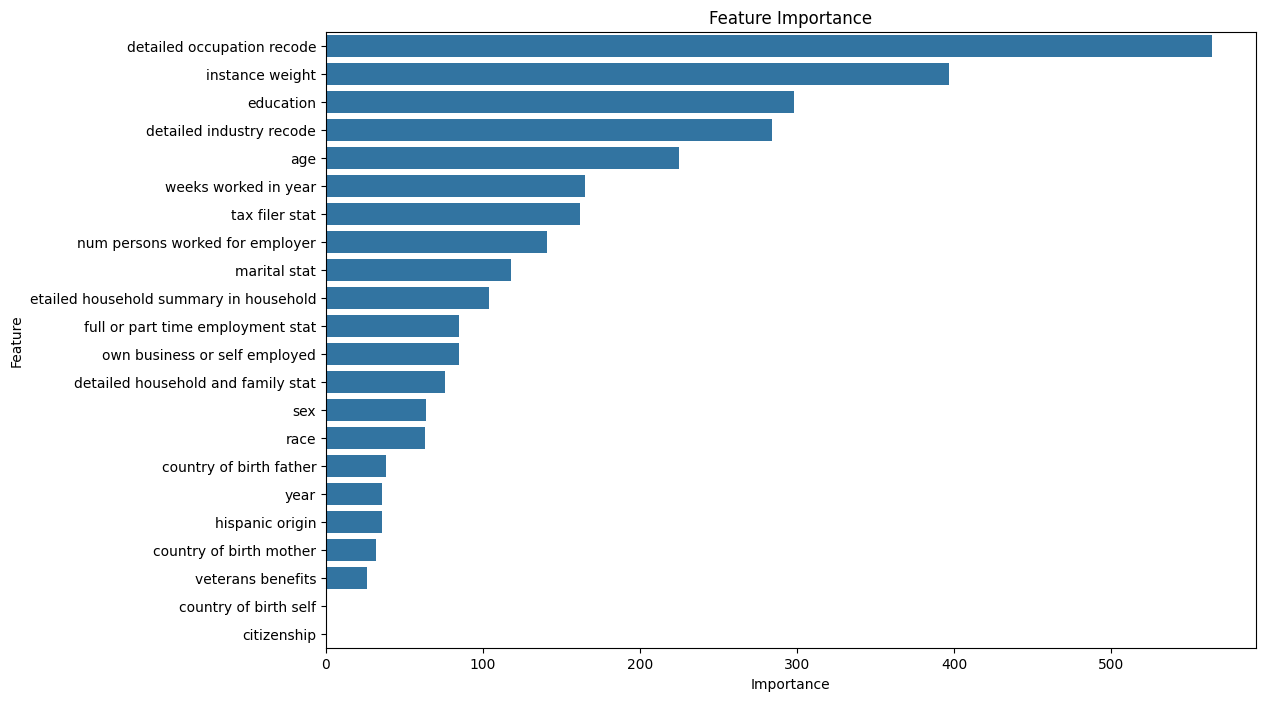

In [12]:
# Feature Importance
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plotting feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

### Predict on validation set

In [15]:
val_file_path = '../data/census_income_test.csv'
df_val = pd.read_csv(val_file_path)
print('preprocessing started')
df_val = preprocessing(df_val, numerical_features, cols2drop, unknown_values)

print('encoding started')
categorical_features = list(set(df_val.columns.tolist()) - set(numerical_features) - set(['income']))
df_val = encoding(df_val, categorical_features)

X_val = df_val.drop(columns=["income"])
y_val = df_val["income"]

preprocessing started
shape of dataframe after dropping unknown values (95536, 23)
shape of dataframe after dropping the duplicated rows is : (94293, 23)
df_clean shape is (94293, 23)
number of Outliers of column age is 0
number of Outliers of column instance weight is 405
number of Outliers of column num persons worked for employer is 0
number of Outliers of column weeks worked in year is 0
shape of dataframe after dropping numerical outliers (94293, 23)
number of Outliers of column tax filer stat is 0
number of Outliers of column detailed occupation recode is 0
number of Outliers of column education is 0
number of Outliers of column hispanic origin is 0
number of Outliers of column country of birth father is 0
number of Outliers of column citizenship is 0
number of Outliers of column full or part time employment stat is 0
number of Outliers of column etailed household summary in household is 0
number of Outliers of column country of birth mother is 0
number of Outliers of column year

In [16]:
y_pred_val = model.predict(X_val)
print("\nClassification Report:\n", classification_report(y_val, y_pred_val))


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96     78787
           1       0.42      0.58      0.49      5110

    accuracy                           0.92     83897
   macro avg       0.69      0.77      0.72     83897
weighted avg       0.94      0.92      0.93     83897



### EXplainability

In [17]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


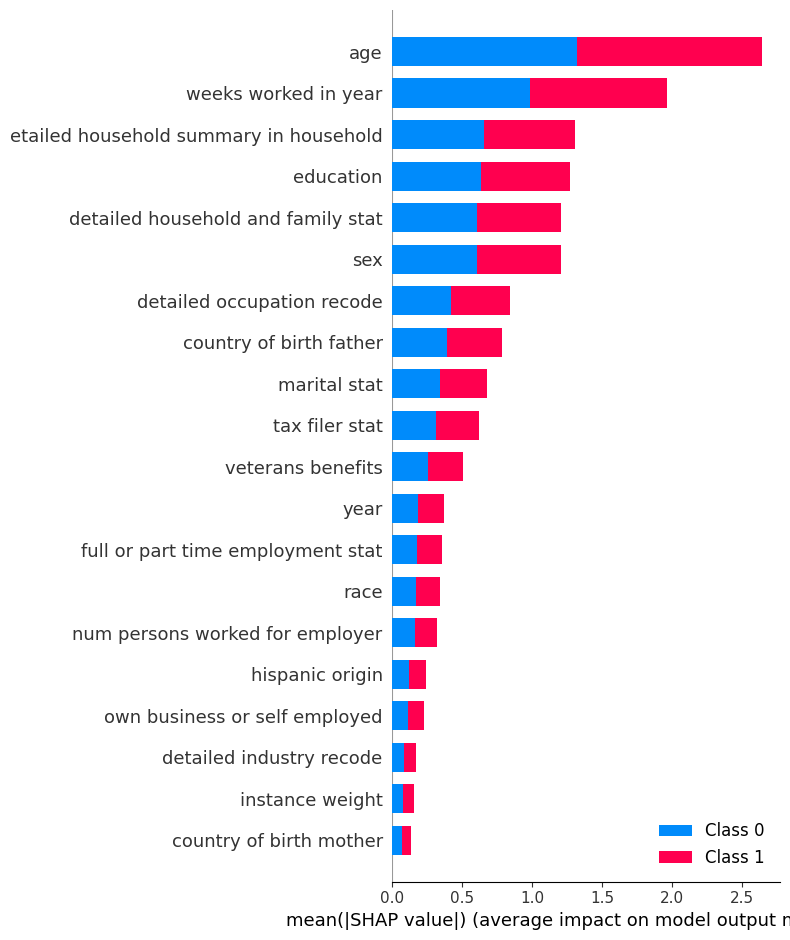

In [18]:
waterfall = shap.summary_plot(shap_values, X_val, feature_names=X_val.columns)


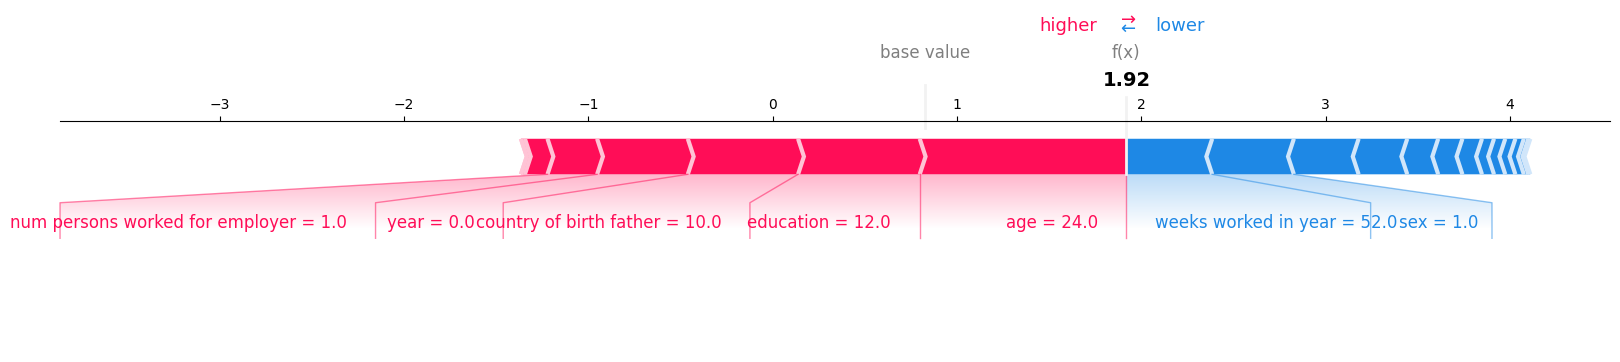

In [23]:
shap.initjs()
class_index = 0 #below 50k
sample_index = 20
force_plot = shap.force_plot(explainer.expected_value[class_index], shap_values[class_index][sample_index, :],
                             X_val.iloc[sample_index, :], matplotlib=matplotlib)

## Future Steps
The notebook concludes with considerations for future steps, including model deployment, potential improvements, and additional features for future iterations.

This project aims to provide insights into predicting income levels using machine learning techniques and serves as a foundation for further analysis and improvements.

### Ethical Considerations in AI: Addressing Age and Race Features

Ethical considerations in AI, particularly when dealing with features like age and race, are crucial to ensure fairness, prevent bias, and promote responsible AI practices. Here are some key principles and techniques to address ethical concerns related to features like age and race in AI##
#
### Bias Assessment:
- Regularly assess your models for bias, particularly in sensitive attributes like race and age.
- Utilize metrics like disparate impact analysis to identify and rectify biased outcom##e#s.

### Fair Representations:
- Ensure that your dataset is representative of the diverse population.
- Make efforts to include a balanced representation of different age groups, races, and ethnicities.
